In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [2]:
def bits_to_symbols(bits, M):
    """Convert bits to M-FSK symbols"""
    bits_per_symbol = int(np.log2(M))
    # Pad bits if necessary
    if len(bits) % bits_per_symbol != 0:
        pad_length = bits_per_symbol - (len(bits) % bits_per_symbol)
        bits = np.append(bits, np.zeros(pad_length))

    # Reshape bits into groups and convert to symbols
    symbols = bits.reshape(-1, bits_per_symbol)
    return np.sum(symbols * (2 ** np.arange(bits_per_symbol)[::-1]), axis=1).astype(int)

def generate_mfsk_signal(symbols, M, samples_per_symbol, fc, freq_sep, fs):
    """
    Generate M-FSK modulated signal
    """
    t = np.arange(0, len(symbols) * samples_per_symbol) / fs

    # Generate M frequencies centered around fc
    frequencies = fc + (np.arange(M) - (M-1)/2) * freq_sep

    # Extend symbol sequence to match time points
    symbol_sequence = np.repeat(symbols, samples_per_symbol)

    # Generate the signal using vectorized operations
    modulated_signal = np.zeros_like(t)
    for i in range(M):
        # Create mask for current symbol
        mask = (symbol_sequence == i)
        # Generate signal for current frequency
        modulated_signal[mask] = np.cos(2 * np.pi * frequencies[i] * t[mask])

    return t, modulated_signal, frequencies

def plot_spectrum_db(signal_data, fs, fc, freq_sep, M, title):
    """Plot frequency spectrum of the signal in dB scale"""
    n = len(signal_data)
    yf = fft(signal_data)
    xf = fftfreq(n, 1/fs)

    # Calculate magnitude spectrum in dB
    magnitude_db = 20 * np.log10(np.abs(yf[:n//2])/n + 1e-10)

    # Plot frequency range around carrier
    freq_range = M * freq_sep  # Adjust range based on M
    freq_mask = (xf[:n//2] >= fc-freq_range) & (xf[:n//2] <= fc+freq_range)
    plt.plot(xf[:n//2][freq_mask], magnitude_db[freq_mask])
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.ylim([-80, 0])

    # Add markers for FSK frequencies
    freqs = fc + (np.arange(M) - (M-1)/2) * freq_sep
    for i, f in enumerate(freqs):
        plt.axvline(x=f, color='r', linestyle='--', alpha=0.3)
        plt.text(f, -10, f'f{i}', rotation=90)

def analyze_mfsk_signals(bits, M_values, fc, fs, freq_sep):
    """Analyze and plot multiple M-FSK signals"""
    plt.figure(figsize=(15, 12))

    for i, M in enumerate(M_values):
        # Convert bits to symbols
        bits_per_symbol = int(np.log2(M))
        symbols = bits_to_symbols(bits, M)

        # Generate modulated signal
        samples_per_symbol = int(fs / freq_sep)  # Adjust for proper sampling
        t, modulated_signal, frequencies = generate_mfsk_signal(
            symbols, M, samples_per_symbol, fc, freq_sep, fs)

        # Plot time domain for first few symbols
        plt.subplot(len(M_values), 2, 2*i+1)
        plot_samples = min(4 * samples_per_symbol, len(t))
        plt.plot(t[:plot_samples], modulated_signal[:plot_samples])
        plt.title(f'{M}-FSK Time Domain (first {4} symbols)')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)

        # Plot spectrum
        plt.subplot(len(M_values), 2, 2*i+2)
        plot_spectrum_db(modulated_signal, fs, fc, freq_sep, M,
                        f'{M}-FSK Frequency Spectrum')

        # Print analysis
        print(f"\n{M}-FSK Analysis:")
        print(f"Bits per symbol: {bits_per_symbol}")
        print(f"Symbol rate: {fs/samples_per_symbol:.1f} symbols/sec")
        print(f"Frequency separation: {freq_sep} Hz")
        print(f"Total bandwidth: {(M-1)*freq_sep} Hz")
        print(f"Spectral efficiency: {bits_per_symbol/((M-1)):.2f} bits/s/Hz")
        print("Frequencies used:", frequencies)
        print("-" * 70)




2-FSK Analysis:
Bits per symbol: 1
Symbol rate: 20.0 symbols/sec
Frequency separation: 20 Hz
Total bandwidth: 20 Hz
Spectral efficiency: 1.00 bits/s/Hz
Frequencies used: [ 90. 110.]
----------------------------------------------------------------------

4-FSK Analysis:
Bits per symbol: 2
Symbol rate: 20.0 symbols/sec
Frequency separation: 20 Hz
Total bandwidth: 60 Hz
Spectral efficiency: 0.67 bits/s/Hz
Frequencies used: [ 70.  90. 110. 130.]
----------------------------------------------------------------------

8-FSK Analysis:
Bits per symbol: 3
Symbol rate: 20.0 symbols/sec
Frequency separation: 20 Hz
Total bandwidth: 140 Hz
Spectral efficiency: 0.43 bits/s/Hz
Frequencies used: [ 30.  50.  70.  90. 110. 130. 150. 170.]
----------------------------------------------------------------------

16-FSK Analysis:
Bits per symbol: 4
Symbol rate: 20.0 symbols/sec
Frequency separation: 20 Hz
Total bandwidth: 300 Hz
Spectral efficiency: 0.27 bits/s/Hz
Frequencies used: [-50. -30. -10.  10.  30

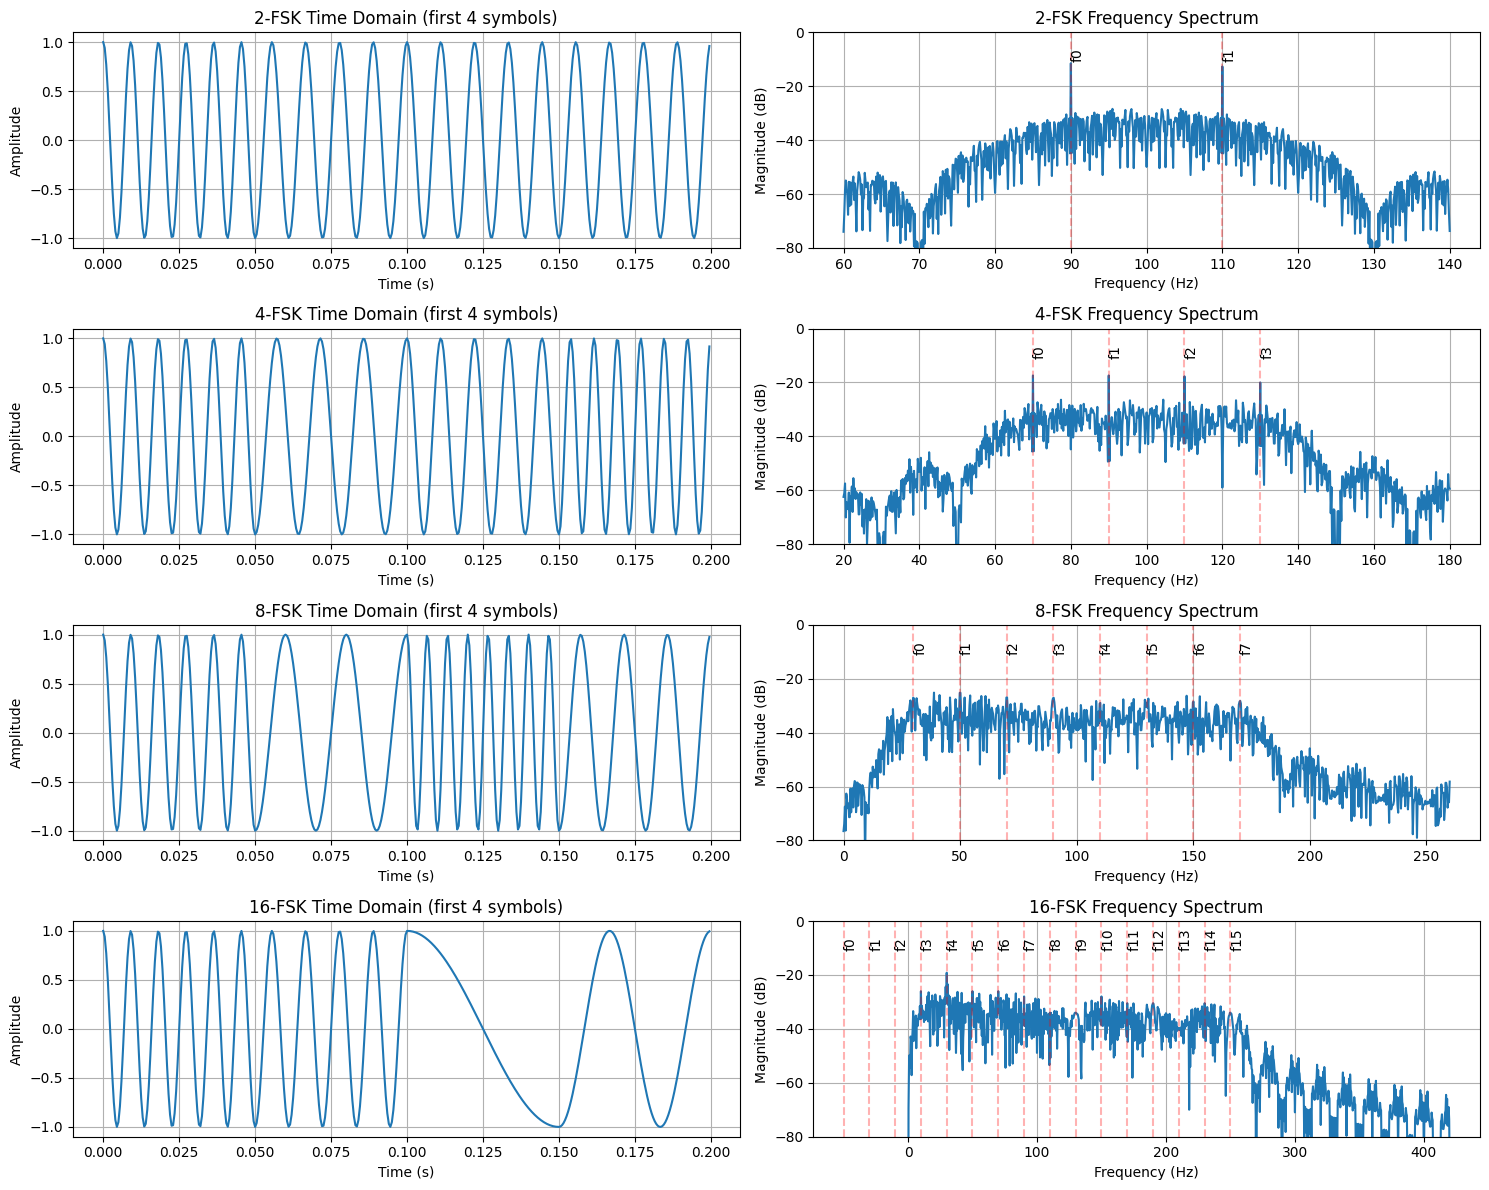

In [3]:
# Parameters
num_bits = 200
fc = 100  # Center frequency (Hz)
freq_sep = 20  # Frequency separation (Hz)
fs = 2000  # Sampling frequency (Hz)
M_values = [2, 4, 8, 16]  # BFSK, 4-FSK, 8-FSK

# Generate random bits
bits = np.random.randint(0, 2, num_bits)

# Analyze signals
analyze_mfsk_signals(bits, M_values, fc, fs, freq_sep)
plt.tight_layout()
plt.show()

## Orthogonality

BFSK Signal Space Analysis:
--------------------------------------------------
Bit period (Tᵦ): 1.0 seconds
Minimum frequency separation (Δf): 0.500 Hz
Signal amplitude (A√(Tᵦ/2)): 0.707

Signal Representations:
s₁(t) = 0.707[1,0]
s₂(t) = 0.707[0,1]
Energy per bit (Eᵦ = A²Tᵦ/2): 0.500
Distance between signals (d = √(2Eᵦ)): 1.000


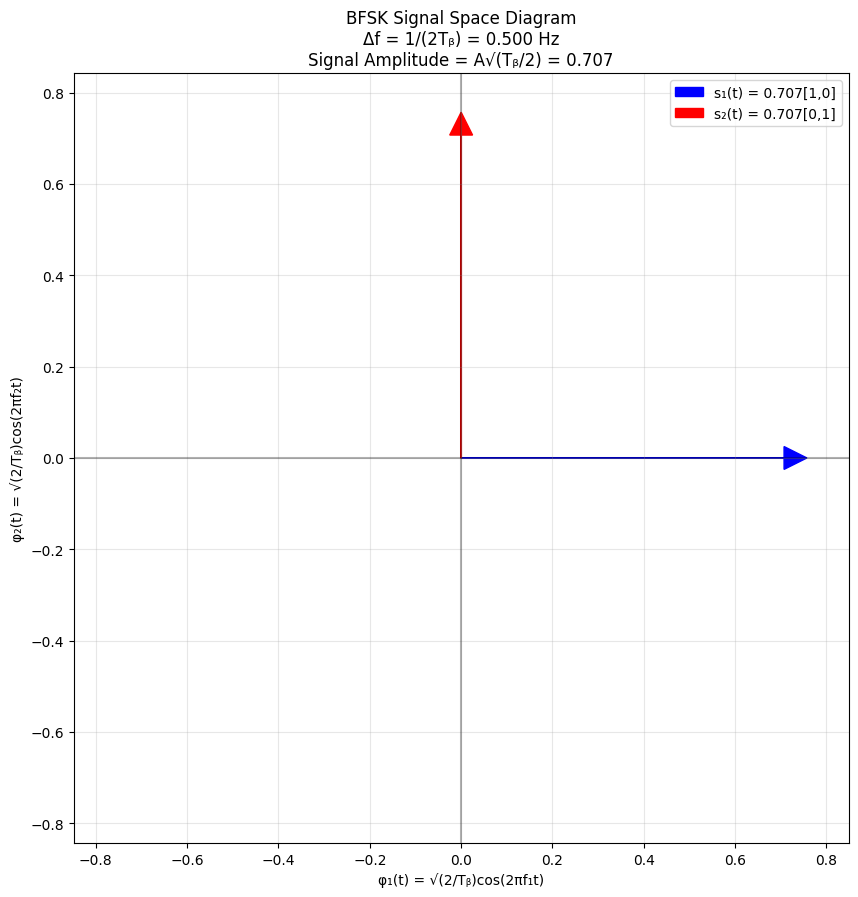

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_signal_space(A, Tb):
    """Plot BFSK signal space diagram with axis representation"""
    plt.figure(figsize=(10, 10))

    # Calculate signal amplitude
    amplitude = A * np.sqrt(Tb/2)

    # Plot signal vectors
    s1 = [amplitude, 0]  # Signal 1 along first axis
    s2 = [0, amplitude]  # Signal 2 along second axis

    plt.arrow(0, 0, s1[0], s1[1], head_width=0.05, head_length=0.05, fc='b', ec='b',
              label=f's₁(t) = {amplitude:.3f}[1,0]')
    plt.arrow(0, 0, s2[0], s2[1], head_width=0.05, head_length=0.05, fc='r', ec='r',
              label=f's₂(t) = {amplitude:.3f}[0,1]')

    # Add labels and grid
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.xlabel('φ₁(t) = √(2/Tᵦ)cos(2πf₁t)')
    plt.ylabel('φ₂(t) = √(2/Tᵦ)cos(2πf₂t)')

    # Set equal aspect ratio and limits
    plt.axis('equal')
    limit = amplitude * 1.2  # Add some margin
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)

    plt.title('BFSK Signal Space Diagram\n'
             f'Δf = 1/(2Tᵦ) = {1/(2*Tb):.3f} Hz\n'
             f'Signal Amplitude = A√(Tᵦ/2) = {amplitude:.3f}')
    plt.legend()

    # Print analysis
    print("BFSK Signal Space Analysis:")
    print("-" * 50)
    print(f"Bit period (Tᵦ): {Tb} seconds")
    print(f"Minimum frequency separation (Δf): {1/(2*Tb):.3f} Hz")
    print(f"Signal amplitude (A√(Tᵦ/2)): {amplitude:.3f}")
    print("\nSignal Representations:")
    print(f"s₁(t) = {amplitude:.3f}[1,0]")
    print(f"s₂(t) = {amplitude:.3f}[0,1]")
    print(f"Energy per bit (Eᵦ = A²Tᵦ/2): {A**2 * Tb/2:.3f}")
    print(f"Distance between signals (d = √(2Eᵦ)): {np.sqrt(2*(A**2 * Tb/2)):.3f}")

# Parameters
A = 1.0     # Signal amplitude
Tb = 1.0    # Bit period (in sec)

# Generate plot
plot_signal_space(A, Tb)
plt.show()


2-FSK Analysis:
--------------------------------------------------
Number of bits per symbol: 1
Signal amplitude in each dimension: 0.707
Minimum frequency separation: 0.500 Hz
Energy per symbol: 0.500
Distance between signals: 1.000

Signal Space Coordinates:
f1: (0.707, 0.000)
f2: (0.000, 0.707)

4-FSK Analysis:
--------------------------------------------------
Number of bits per symbol: 2
Signal amplitude in each dimension: 0.707
Minimum frequency separation: 0.500 Hz
Energy per symbol: 0.500
Distance between signals: 1.000

Signal Space Coordinates:
f1: (0.707, 0.000)
f2: (0.000, 0.707)
f3: (orthogonal to shown plane)
f4: (orthogonal to shown plane)

8-FSK Analysis:
--------------------------------------------------
Number of bits per symbol: 3
Signal amplitude in each dimension: 0.707
Minimum frequency separation: 0.500 Hz
Energy per symbol: 0.500
Distance between signals: 1.000

Signal Space Coordinates:
f1: (0.707, 0.000)
f2: (0.000, 0.707)
f3: (orthogonal to shown plane)
f4: 

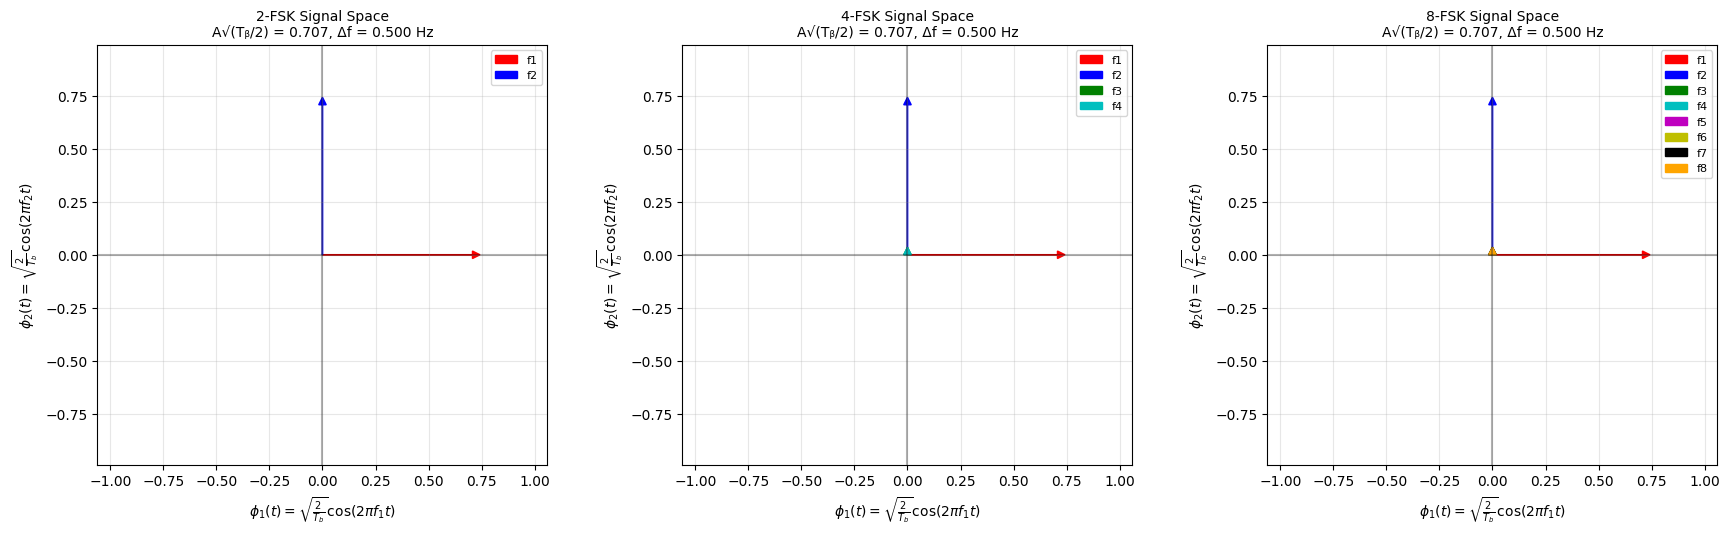


Theoretical Comparison:
--------------------------------------------------

2-FSK:
Bits per symbol: 1
Symbol energy (Es): 0.500
Energy per bit (Eb): 0.500
Bandwidth: 0.500 Hz
Spectral efficiency: 1.000 bits/s/Hz

4-FSK:
Bits per symbol: 2
Symbol energy (Es): 0.500
Energy per bit (Eb): 0.250
Bandwidth: 1.500 Hz
Spectral efficiency: 0.667 bits/s/Hz

8-FSK:
Bits per symbol: 3
Symbol energy (Es): 0.500
Energy per bit (Eb): 0.167
Bandwidth: 3.500 Hz
Spectral efficiency: 0.429 bits/s/Hz


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mfsk_signal_space(M, A=1, Tb=1):
    """Plot MFSK signal space representation"""
    # Calculate signal amplitude in each dimension
    amplitude = A * np.sqrt(Tb/2)

    # Plot signal points
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange']
    points = []

    for i in range(M):
        # For M-FSK, each signal lies on its own axis in M-dimensional space
        if i == 0:
            point = [amplitude, 0]
        elif i == 1:
            point = [0, amplitude]
        else:
            point = [0, 0]  # Can't show in 2D

        points.append(point)
        plt.arrow(0, 0, point[0], point[1],
                 head_width=amplitude*0.05, head_length=amplitude*0.05,
                 fc=colors[i], ec=colors[i],
                 label=f'f{i+1}')

    # Add labels and grid
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)

    # Set axis labels
    plt.xlabel(r'$\phi_1(t) = \sqrt{\frac{2}{T_b}}\cos(2\pi f_1t)$', fontsize=10)
    plt.ylabel(r'$\phi_2(t) = \sqrt{\frac{2}{T_b}}\cos(2\pi f_2t)$', fontsize=10)

    # Set equal aspect ratio and limits
    plt.axis('equal')
    limit = amplitude * 1.5  # Increased margin
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)

    # Add title and legend
    plt.title(f'{M}-FSK Signal Space\n' +
             f'A√(Tᵦ/2) = {amplitude:.3f}, Δf = {1/(2*Tb):.3f} Hz',
             fontsize=10)
    plt.legend(fontsize=8)

    # Print analysis
    print(f"\n{M}-FSK Analysis:")
    print("-" * 50)
    print(f"Number of bits per symbol: {int(np.log2(M))}")
    print(f"Signal amplitude in each dimension: {amplitude:.3f}")
    print(f"Minimum frequency separation: {1/(2*Tb):.3f} Hz")
    print(f"Energy per symbol: {A**2 * Tb/2:.3f}")
    print(f"Distance between signals: {np.sqrt(2*(A**2 * Tb/2)):.3f}")

    # Print signal space coordinates
    print("\nSignal Space Coordinates:")
    for i, point in enumerate(points):
        if i < 2:
            print(f"f{i+1}: ({point[0]:.3f}, {point[1]:.3f})")
        else:
            print(f"f{i+1}: (orthogonal to shown plane)")

# Create a figure with proper size and spacing
plt.figure(figsize=(18, 6))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.85, wspace=0.3)

M_values = [2, 4, 8]

for idx, M in enumerate(M_values, 1):
    plt.subplot(1, 3, idx)
    plot_mfsk_signal_space(M)

plt.show()

# Print theoretical comparison
print("\nTheoretical Comparison:")
print("-" * 50)
Tb = 1
A = 1
for M in M_values:
    bits_per_symbol = int(np.log2(M))
    Es = A**2 * Tb/2
    Eb = Es/bits_per_symbol
    print(f"\n{M}-FSK:")
    print(f"Bits per symbol: {bits_per_symbol}")
    print(f"Symbol energy (Es): {Es:.3f}")
    print(f"Energy per bit (Eb): {Eb:.3f}")
    print(f"Bandwidth: {(M-1)/(2*Tb):.3f} Hz")
    print(f"Spectral efficiency: {bits_per_symbol/((M-1)):.3f} bits/s/Hz")